In [1]:
import arviz as az
import pymc as pm
from pymc.math import switch, ge
from pymc.math import dot, invlogit
import pandas as pd
import numpy as np
import pytensor
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot  as plt
from nba_api.stats.endpoints import leaguegamefinder


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Code to get all 2023-2024 NBA regular season games. No playoffs to avoid multiple repeat head to head matches which can influence outcomes

# game_finder = leaguegamefinder.LeagueGameFinder(
#     season_nullable='2023-24',
#     season_type_nullable='Regular Season', # No playoffs 
#     league_id_nullable='00' # Only NBA, no G League
# )

# regular_season_games_24_25 = game_finder.get_data_frames()[0]

# print(regular_season_games_24_25.head())

# Save as CSV to easy load
# regular_season_games_24_25.to_csv('regular_season_games_24_25.csv', index = False)

In [3]:
regular_season_games_23_24 = pd.read_csv('regular_season_games_23-24.csv')

n_teams = regular_season_games_23_24['TEAM_ABBREVIATION'].nunique()
n_games = len(regular_season_games_23_24)

regular_season_games_23_24['is_home'] = regular_season_games_23_24['MATCHUP'].str.contains('vs').astype(int)

regular_season_games_23_24['opponent'] = regular_season_games_23_24['MATCHUP'].str.extract(r'@\s*(.*)$|vs.\s*(.*)$').fillna('').sum(axis=1)

teams = pd.concat([regular_season_games_23_24['TEAM_ABBREVIATION'], regular_season_games_23_24['opponent']]).unique()
team_idx = {team: i for i, team in enumerate(teams)}

# Get 2PT shot type
regular_season_games_23_24['2PTA'] = regular_season_games_23_24['FGA'] - regular_season_games_23_24['FG3A']
regular_season_games_23_24['2PT'] = regular_season_games_23_24['FGM'] - regular_season_games_23_24['FG3M']
regular_season_games_23_24['2PT_PCT'] = regular_season_games_23_24['2PT'] / regular_season_games_23_24['2PTA']

regular_season_games_23_24 = regular_season_games_23_24.rename(columns = {'FTM':'FT', 'FG3M':'3PT'})
regular_season_games_23_24.columns
regular_season_games_23_24['calculated_PTS'] = regular_season_games_23_24['FT'] + 2 * regular_season_games_23_24['2PT'] + 3 * regular_season_games_23_24['3PT']
assert all(regular_season_games_23_24['PTS'] == regular_season_games_23_24['calculated_PTS']), "Mismatch in total points calculation"

# Map teams to unique IDS
regular_season_games_23_24['team_idx'] = regular_season_games_23_24['TEAM_ABBREVIATION'].map(team_idx)
regular_season_games_23_24['opponent_idx'] = regular_season_games_23_24['opponent'].map(team_idx)
regular_season_games_23_24['OPP_PTS'] = regular_season_games_23_24['PTS'] -  regular_season_games_23_24['PLUS_MINUS']

# subset necessary cols
regular_season_games_23_24_model = regular_season_games_23_24[['GAME_ID', 'team_idx', 'opponent_idx', 'is_home', 'FT', '2PT', '3PT', 'PTS','FT_PCT', '2PT_PCT', 'FG3_PCT', 'PLUS_MINUS']]
regular_season_games_23_24_model.sort_values(by = 'GAME_ID').head(5)

,GAME_ID,team_idx,opponent_idx,is_home,FT,2PT,3PT,PTS,FT_PCT,2PT_PCT,FG3_PCT,PLUS_MINUS
2317,22300001,12,21,0,20,36,8,116,0.800,0.642857,0.286,-5.0
2307,22300001,21,12,1,16,30,15,121,0.667,0.545455,0.484,5.0
2306,22300002,24,28,1,20,15,20,110,0.714,0.348837,0.513,5.0
2309,22300002,28,24,0,19,28,10,105,0.760,0.491228,0.256,-5.0
2315,22300003,29,23,1,12,35,13,121,0.857,0.660377,0.481,7.0


In [4]:
# untack data
home_games = regular_season_games_23_24_model[regular_season_games_23_24_model['is_home'] == 1]
away_games = regular_season_games_23_24_model[regular_season_games_23_24_model['is_home'] == 0]

merged = pd.merge(home_games, away_games, left_on=['GAME_ID', 'team_idx','opponent_idx'], right_on=['GAME_ID', 'opponent_idx','team_idx'])

merged = merged.drop(columns=['is_home_x', 'team_idx_y', 'opponent_idx_y', 'is_home_y','PLUS_MINUS_y'])

merged = merged.rename(columns = {'GAME_ID':'GAME_ID', 'team_idx_x' : 'team_idx','opponent_idx_x':'opponent_idx', 'FT_x':'home_FT',
                                  '2PT_x':'home_2PT','3PT_x':'home_3PT', 'FT_PCT_x' : 'home_FT_PCT', '2PT_PCT_x' : 'home_2PT_PCT',
                                   'FG3_PCT_x': 'home_FG3_PCT', 'PLUS_MINUS_x':'PLUS_MINUS', 'FT_y' :'away_FT',
                                   '2PT_y':'away_2PT','3PT_y':'away_3PT', 'FT_PCT_y' : 'away_FT_PCT', '2PT_PCT_y':'away_2PT_PCT', 
                                   'FG3_PCT_y':'away_FG3_PCT', 'PTS_x':'total_home_points','PTS_y':'total_away_points' })

merged['home_win'] = np.where(merged['PLUS_MINUS'] >= 0, 1, 0)

regular_season_games_23_24_model_unstacked = merged

regular_season_games_23_24_model_unstacked.sort_values(by='GAME_ID').head(5)

,GAME_ID,team_idx,opponent_idx,home_FT,home_2PT,home_3PT,total_home_points,home_FT_PCT,home_2PT_PCT,home_FG3_PCT,PLUS_MINUS,away_FT,away_2PT,away_3PT,total_away_points,away_FT_PCT,away_2PT_PCT,away_FG3_PCT,home_win
1155,22300001,21,12,16,30,15,121,0.667,0.545455,0.484,5.0,20,36,8,116,0.800,0.642857,0.286,1
1154,22300002,24,28,20,15,20,110,0.714,0.348837,0.513,5.0,19,28,10,105,0.760,0.491228,0.256,1
1157,22300003,29,23,12,35,13,121,0.857,0.660377,0.481,7.0,9,33,13,114,0.529,0.622642,0.464,1
1153,22300004,3,27,10,32,11,107,0.714,0.524590,0.393,-2.0,3,26,18,109,0.600,0.509804,0.400,0
1158,22300005,7,8,24,35,15,139,0.800,0.648148,0.517,-2.0,25,31,18,141,0.833,0.596154,0.450,0


In [5]:
# # Model 1, same as paper

# # Model 1 following the paper. 
# with pm.Model() as model:
#     home_adv_ft = pm.Normal("home_adv_ft", mu=0, tau=0.0001)
#     home_adv_2pt = pm.Normal("home_adv_2pt", mu=0, tau=0.0001)
#     home_adv_3pt = pm.Normal("home_adv_3pt", mu=0, tau=0.0001)
    
#     intercept_ft = pm.Normal("intercept_ft", mu=0, tau=0.0001)
#     intercept_2pt = pm.Normal("intercept_2pt", mu=0, tau=0.0001)
#     intercept_3pt = pm.Normal("intercept_3pt", mu=0, tau=0.0001)
    
#     tau_att_ft = pm.Gamma('tau_att_ft', mu = 0.1, sigma = 0.1, shape = n_teams)
#     tau_att_2pt = pm.Gamma('tau_att_2pt', mu = 0.1, sigma = 0.1, shape = n_teams)
#     tau_att_3pt = pm.Gamma('tau_att_3pt', mu = 0.1, sigma = 0.1, shape = n_teams)
    
#     tau_def_ft = pm.Gamma('tau_def_ft', mu = 0.1, sigma = 0.1, shape = n_teams)
#     tau_def_2pt = pm.Gamma('tau_def_2pt', mu = 0.1, sigma = 0.1, shape = n_teams)
#     tau_def_3pt = pm.Gamma('tau_def_3pt', mu = 0.1, sigma = 0.1, shape = n_teams)
    
#     mu_att_ft = pm.Normal('mu_att_ft', 0, tau = 0.0001, shape = n_teams)
#     mu_att_2pt = pm.Normal('mu_att_2pt', 0, tau = 0.0001, shape = n_teams)
#     mu_att_3pt = pm.Normal('mu_att_3pt', 0, tau = 0.0001, shape = n_teams)
    
#     mu_def_ft = pm.Normal('mu_def_ft', 0, tau = 0.0001, shape = n_teams)
#     mu_def_2pt = pm.Normal('mu_def_2pt', 0, tau = 0.0001, shape = n_teams)
#     mu_def_3pt = pm.Normal('mu_def_3pt', 0, tau = 0.0001, shape = n_teams)
    
#     att_ft_unconstrained = pm.Normal('att_ft_unconstrained', mu = mu_att_ft, tau=tau_att_ft, shape = n_teams)
#     att_2pt_unconstrained = pm.Normal('att_2pt_unconstrained', mu = mu_att_2pt, tau=tau_att_2pt, shape = n_teams)
#     att_3pt_unconstrained = pm.Normal('att_3pt_unconstrained', mu = mu_att_3pt, tau=tau_att_3pt, shape = n_teams)

#     att_ft = pm.Deterministic('att_ft', att_ft_unconstrained - pm.math.mean(att_ft_unconstrained))
#     att_2pt = pm.Deterministic('att_2pt', att_2pt_unconstrained - pm.math.mean(att_2pt_unconstrained))
#     att_3pt = pm.Deterministic('att_3pt', att_3pt_unconstrained - pm.math.mean(att_3pt_unconstrained))
    
#     def_ft_unconstrained = pm.Normal('def_ft_unconstrained', mu = mu_def_ft, tau=tau_def_ft, shape = n_teams)
#     def_2pt_unconstrained = pm.Normal('def_2pt_unconstrained', mu = mu_def_2pt, tau=tau_def_2pt, shape = n_teams)
#     def_3pt_unconstrained = pm.Normal('def_3pt_unconstrained', mu = mu_def_3pt, tau=tau_def_3pt, shape = n_teams)

#     def_ft = pm.Deterministic('def_ft', def_ft_unconstrained - pm.math.mean(def_ft_unconstrained))
#     def_2pt = pm.Deterministic('def_2pt', def_2pt_unconstrained - pm.math.mean(def_2pt_unconstrained))
#     def_3pt = pm.Deterministic('def_3pt', def_3pt_unconstrained - pm.math.mean(def_3pt_unconstrained))
    
#     r_ft_home = pm.Deterministic('r_ft_home', pm.math.exp(intercept_ft + att_ft[regular_season_games_23_24_model_unstacked['team_idx']] 
#                                                           + def_ft[regular_season_games_23_24_model_unstacked['opponent_idx']] + home_adv_ft))
        
#     r_2pt_home = pm.Deterministic('r_2pt_home', pm.math.exp(intercept_2pt + att_2pt[regular_season_games_23_24_model_unstacked['team_idx']] 
#                                                             + def_2pt[regular_season_games_23_24_model_unstacked['opponent_idx']] + home_adv_2pt))
    
#     r_3pt_home = pm.Deterministic('r_3pt_home', pm.math.exp(intercept_3pt + att_3pt[regular_season_games_23_24_model_unstacked['team_idx']] 
#                                                             + def_3pt[regular_season_games_23_24_model_unstacked['opponent_idx']] + home_adv_3pt))    
    
#     r_ft_away = pm.Deterministic('r_ft_away', pm.math.exp(intercept_ft + att_ft[regular_season_games_23_24_model_unstacked['opponent_idx']] 
#                                                           + def_ft[regular_season_games_23_24_model_unstacked['team_idx']]))
    
#     r_2pt_away = pm.Deterministic('r_2pt_away', pm.math.exp(intercept_2pt + att_2pt[regular_season_games_23_24_model_unstacked['opponent_idx']] 
#                                                             + def_2pt[regular_season_games_23_24_model_unstacked['team_idx']]))
    
#     r_3pt_away = pm.Deterministic('r_3pt_away', pm.math.exp(intercept_3pt + att_3pt[regular_season_games_23_24_model_unstacked['opponent_idx']] 
#                                                             + def_3pt[regular_season_games_23_24_model_unstacked['team_idx']]))

#     l_ft_home = pm.Beta('l_ft_home', 0, 1)
#     l_2pt_home = pm.Uniform('l_2pt_home', 0, 1)
#     l_3pt_home = pm.Uniform('l_3pt_home', 0, 1) 
    
#     l_ft_away = pm.Uniform('l_ft_away', 0 , 1) 
#     l_2pt_away = pm.Uniform('l_2pt_away', 0, 1)
#     l_3pt_away = pm.Uniform('l_3pt_away', 0, 1)
    
#     home_ft_obs = pm.Data("home_ft_obs", regular_season_games_23_24_model_unstacked["home_FT"])
#     home_2pt_obs = pm.Data("home_2pt_obs", regular_season_games_23_24_model_unstacked["home_2PT"])
#     home_3pt_obs = pm.Data("home_3pt_obs", regular_season_games_23_24_model_unstacked["home_3PT"])

#     away_ft_obs = pm.Data("away_ft_obs", regular_season_games_23_24_model_unstacked["away_FT"])
#     away_2pt_obs = pm.Data("away_2pt_obs", regular_season_games_23_24_model_unstacked["away_2PT"])
#     away_3pt_obs = pm.Data("away_3pt_obs", regular_season_games_23_24_model_unstacked["away_3PT"])
    
#     home_ft = pm.NegativeBinomial('ft_home', p = l_ft_home, n = r_ft_home, observed = home_ft_obs)
#     away_ft = pm.NegativeBinomial('ft_away', p = l_ft_away, n = r_ft_away, observed = away_ft_obs)
    
#     home_2pt = pm.NegativeBinomial('2pt_home', p = l_2pt_home, n = r_2pt_home, observed = home_2pt_obs)
#     away_2pt = pm.NegativeBinomial('2pt_away', p = l_2pt_away, n = r_2pt_away, observed = away_2pt_obs)
    
#     home_3pt = pm.NegativeBinomial('3pt_home', p = l_3pt_home, n = r_3pt_home, observed = home_3pt_obs)
#     away_3pt = pm.NegativeBinomial('3pt_away', p = l_3pt_home, n = r_3pt_away, observed = away_3pt_obs)
    
#     TP_home = pm.Deterministic('TP_home', home_ft + (2 * home_2pt) + (3 * home_3pt))
#     TP_away = pm.Deterministic('TP_away', away_ft + (2 * away_2pt) + (3 * away_3pt))
    
#     spread = pm.Deterministic('spread', TP_home - TP_away)
    
    
#     trace_23_24 = pm.sample(2000, tune=1000, target_accept = 0.95, return_inferencedata=True)
#     
# results_23_24 = az.summary(trace_23_24, hdi_prob = 0.95)
# results_23_24 

In [6]:
# Code to save trace and load trace. Code from : https://discourse.pymc.io/t/how-to-save-my-trace-in-the-system/7222

# trace_23_24.to_netcdf("trace_23_24.nc")
trace_23_24 = az.from_netcdf("trace_23_24.nc")
results_23_24 = az.summary(trace_23_24, hdi_prob=0.95)
results_23_24

c:\Users\peter\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home_adv_ft,0.092,0.132,-0.169,0.347,0.004,0.003,1004.0,1805.0,1.00
home_adv_2pt,0.194,1.818,-3.368,4.046,0.073,0.052,638.0,840.0,1.00
home_adv_3pt,0.027,0.012,0.006,0.051,0.000,0.000,2631.0,4056.0,1.00
intercept_ft,2.944,0.092,2.770,3.127,0.003,0.002,1105.0,2146.0,1.00
intercept_2pt,8.798,1.256,6.615,11.349,0.051,0.037,760.0,646.0,1.01
...,...,...,...,...,...,...,...,...,...
spread[1225],-1.000,0.000,-1.000,-1.000,0.000,0.000,8000.0,8000.0,NaN
spread[1226],-7.000,0.000,-7.000,-7.000,0.000,0.000,8000.0,8000.0,NaN
spread[1227],30.000,0.000,30.000,30.000,0.000,0.000,8000.0,8000.0,NaN
spread[1228],12.000,0.000,12.000,12.000,0.000,0.000,8000.0,8000.0,NaN


In [7]:
subset_23_24 = results_23_24[(results_23_24['r_hat'] > 1.01)]
subset_23_24

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_att_ft[19],-0.451,7.832,-14.474,15.605,0.491,0.348,451.0,337.0,1.02
mu_att_2pt[0],0.136,6.264,-12.560,13.293,0.365,0.259,228.0,473.0,1.02
mu_att_2pt[1],-0.151,6.910,-13.464,14.119,0.335,0.237,282.0,480.0,1.03
mu_att_2pt[2],-0.344,7.623,-15.268,16.194,0.524,0.371,174.0,359.0,1.03
mu_att_2pt[6],-0.873,9.623,-16.794,13.918,1.083,0.769,172.0,166.0,1.03
...,...,...,...,...,...,...,...,...,...
def_3pt_unconstrained[28],-0.406,0.416,-1.199,0.457,0.197,0.149,5.0,11.0,2.97
def_3pt_unconstrained[29],-0.362,0.416,-1.224,0.439,0.197,0.149,5.0,11.0,2.97
tau_def_2pt[4],0.094,0.100,0.000,0.291,0.004,0.003,148.0,41.0,1.03
tau_def_3pt[27],0.097,0.102,0.000,0.299,0.003,0.002,249.0,90.0,1.02


c:\Users\peter\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\plots\plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (180) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'l_ft_home'}>,
        <Axes: title={'center': 'l_2pt_home'}>,
        <Axes: title={'center': 'l_3pt_home'}>],
       [<Axes: title={'center': 'l_ft_away'}>,
        <Axes: title={'center': 'l_2pt_away'}>,
        <Axes: title={'center': 'l_3pt_away'}>]], dtype=object)

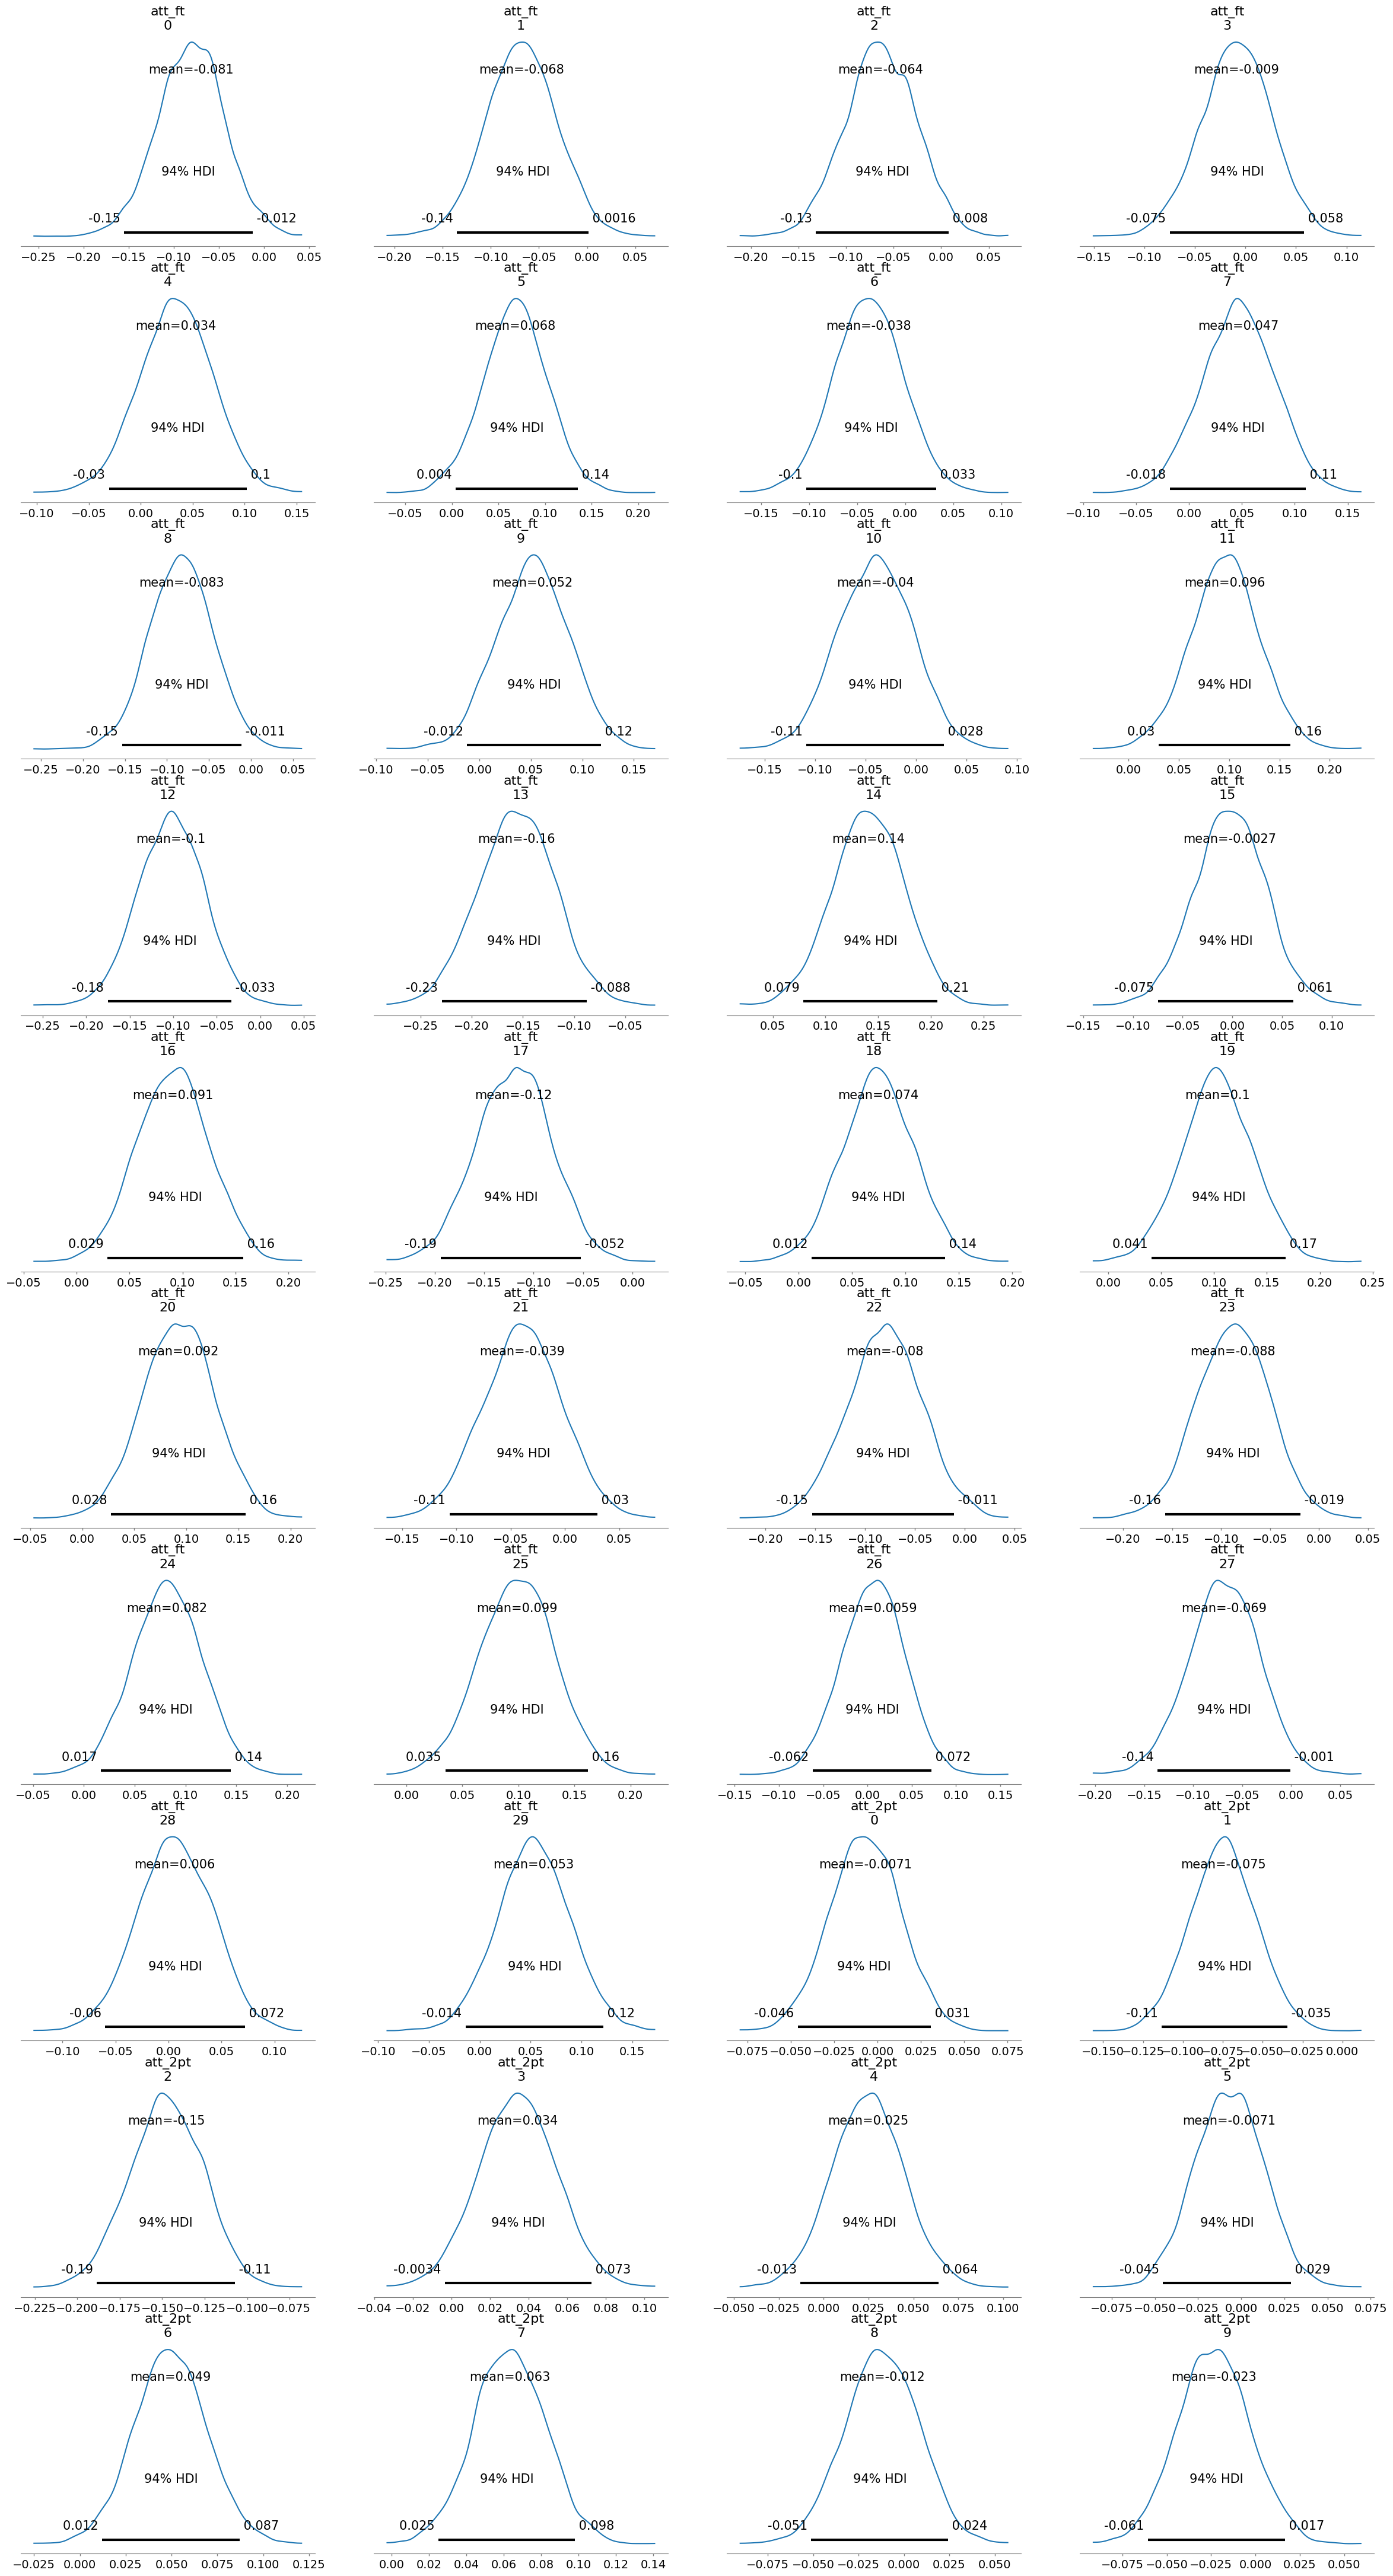

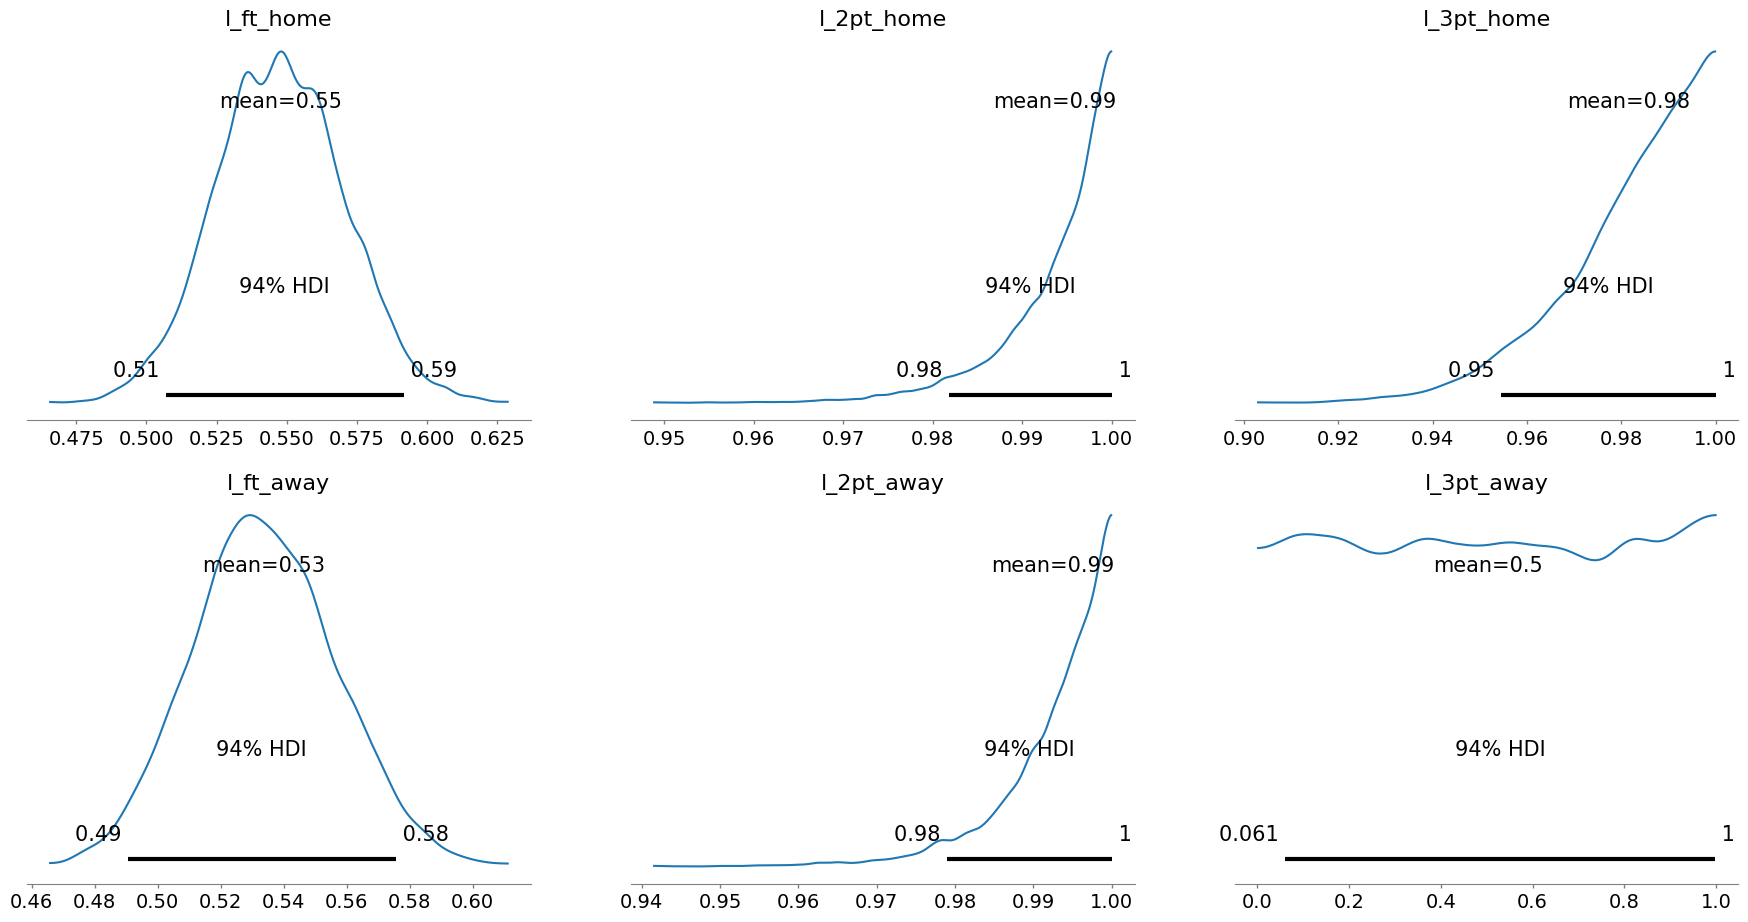

In [8]:
# code to get all paramters vals and plots that wont fit into the report
# az.summary(trace_23_24, var_names=['att_ft', 'intercept_ft', 'att_2pt', 'intercept_2pt', 'att_3pt', 'intercept_3pt']).to_csv('23_24_attacking_intensities.csv')
# az.summary(trace_23_24, var_names=['def_ft', 'intercept_ft', 'def_2pt', 'intercept_2pt', 'def_3pt', 'intercept_3pt']).to_csv('23_24_defending_intensities.csv')
# az.summary(trace_23_24, var_names=['l_ft_home', 'l_2pt_home', 'l_3pt_home', 'l_ft_away', 'l_2pt_away', 'l_3pt_away']).to_csv('23_24_scoring_intensities.csv')
az.plot_posterior(trace_23_24, var_names=['att_ft', 'att_2pt', 'att_3pt', 'def_ft', 'def_2pt', 'def_3pt'])
az.plot_posterior(trace_23_24, var_names=['l_ft_home', 'l_2pt_home', 'l_3pt_home', 'l_ft_away', 'l_2pt_away', 'l_3pt_away'])

In [9]:
# Code to get 2024-2025 NBA regular season games played so far

# game_finder = leaguegamefinder.LeagueGameFinder(
#     season_nullable='2024-25',
#     season_type_nullable='Regular Season',
#     league_id_nullable='00' # Only NBA, no G League
# )

# regular_season_games_24_25 = game_finder.get_data_frames()[0]

# print(regular_season_games_24_25.head())

# regular_season_games_24_25.to_csv('regular_season_games_24_25.csv', index = False)

In [10]:
regular_season_games_24_25 = pd.read_csv('regular_season_games_24_25.csv')

n_teams = regular_season_games_24_25['TEAM_ABBREVIATION'].nunique()
n_games = len(regular_season_games_24_25)

regular_season_games_24_25['is_home'] = regular_season_games_24_25['MATCHUP'].str.contains('vs').astype(int)

regular_season_games_24_25['opponent'] = regular_season_games_24_25['MATCHUP'].str.extract(r'@\s*(.*)$|vs.\s*(.*)$').fillna('').sum(axis=1)

# Get 2PT stats
regular_season_games_24_25['2PTA'] = regular_season_games_24_25['FGA'] - regular_season_games_24_25['FG3A']
regular_season_games_24_25['2PT'] = regular_season_games_24_25['FGM'] - regular_season_games_24_25['FG3M']
regular_season_games_24_25['2PT_PCT'] = regular_season_games_24_25['2PT'] / regular_season_games_24_25['2PTA']

regular_season_games_24_25 = regular_season_games_24_25.rename(columns = {'FTM':'FT', 'FG3M':'3PT'})

regular_season_games_24_25['calculated_PTS'] = regular_season_games_24_25['FT'] + 2 * regular_season_games_24_25['2PT'] + 3 * regular_season_games_24_25['3PT']
assert all(regular_season_games_24_25['PTS'] == regular_season_games_24_25['calculated_PTS']), "Mismatch in total points calculation"

# Reuse previously defined team index to avoid any possible changes in unique index
regular_season_games_24_25['team_idx'] = regular_season_games_24_25['TEAM_ABBREVIATION'].map(team_idx)
regular_season_games_24_25['opponent_idx'] = regular_season_games_24_25['opponent'].map(team_idx)

# regular_season_games_24_25['OPP_PTS'] = regular_season_games_24_25['PTS'] -  regular_season_games_24_25['PLUS_MINUS']

regular_season_games_24_25_model = regular_season_games_24_25[['GAME_ID', 'team_idx', 'opponent_idx', 'is_home', 'FT', '2PT', '3PT', 'PTS','FT_PCT', '2PT_PCT', 'FG3_PCT', 'PLUS_MINUS']]
regular_season_games_24_25_model.sort_values(by = 'GAME_ID').head(5)


,GAME_ID,team_idx,opponent_idx,is_home,FT,2PT,3PT,PTS,FT_PCT,2PT_PCT,FG3_PCT,PLUS_MINUS
243,22400001,16,1,0,7,40,10,117,0.538,0.597015,0.313,1.0
241,22400001,1,16,1,22,20,18,116,0.815,0.666667,0.400,-1.0
242,22400002,29,26,0,10,30,17,121,0.769,0.535714,0.378,-2.0
240,22400002,26,29,1,24,30,13,123,0.857,0.535714,0.361,2.0
232,22400003,13,20,0,8,21,13,89,0.571,0.456522,0.342,-25.0


In [11]:
# "unstack" data again

home_games = regular_season_games_24_25_model[regular_season_games_24_25_model['is_home'] == 1]
away_games = regular_season_games_24_25_model[regular_season_games_24_25_model['is_home'] == 0]

merged = pd.merge(home_games, away_games, left_on=['GAME_ID', 'team_idx','opponent_idx'], right_on=['GAME_ID', 'opponent_idx','team_idx'])

merged = merged.drop(columns=['is_home_x', 'team_idx_y', 'opponent_idx_y', 'is_home_y','PLUS_MINUS_y'])

merged = merged.rename(columns = {'GAME_ID':'GAME_ID', 'team_idx_x' : 'team_idx','opponent_idx_x':'opponent_idx', 'FT_x':'home_FT',
                                  '2PT_x':'home_2PT','3PT_x':'home_3PT', 'FT_PCT_x' : 'home_FT_PCT', '2PT_PCT_x' : 'home_2PT_PCT',
                                   'FG3_PCT_x': 'home_FG3_PCT', 'PLUS_MINUS_x':'PLUS_MINUS', 'FT_y' :'away_FT',
                                   '2PT_y':'away_2PT','3PT_y':'away_3PT', 'FT_PCT_y' : 'away_FT_PCT', '2PT_PCT_y':'away_2PT_PCT', 
                                   'FG3_PCT_y':'away_FG3_PCT', 'PTS_x':'total_home_points','PTS_y':'total_away_points' })

merged['home_win'] = np.where(merged['PLUS_MINUS'] >= 0, 1, 0)

regular_season_games_24_25_model_unstacked = merged

regular_season_games_24_25_model_unstacked.sort_values(by='GAME_ID').head(5)

,GAME_ID,team_idx,opponent_idx,home_FT,home_2PT,home_3PT,total_home_points,home_FT_PCT,home_2PT_PCT,home_FG3_PCT,PLUS_MINUS,away_FT,away_2PT,away_3PT,total_away_points,away_FT_PCT,away_2PT_PCT,away_FG3_PCT,home_win
121,22400001,1,16,22,20,18,116,0.815,0.666667,0.400,-1.0,7,40,10,117,0.538,0.597015,0.313,0
120,22400002,26,29,24,30,13,123,0.857,0.535714,0.361,2.0,10,30,17,121,0.769,0.535714,0.378,1
118,22400003,20,13,15,30,13,114,0.789,0.612245,0.295,25.0,8,21,13,89,0.571,0.456522,0.342,1
117,22400004,14,28,23,17,14,99,0.958,0.414634,0.333,-12.0,14,35,9,111,0.933,0.603448,0.290,0
116,22400005,24,6,7,22,16,99,0.583,0.578947,0.286,14.0,16,21,9,85,0.800,0.344262,0.360,1


In [12]:
# # Updated model, use previous model posteriors on the vars as prior values 
# # Change l to beta(1,1) instead of uniform(0,1)

# # a 
# with pm.Model() as updated_model:
#     home_adv_ft = pm.Normal("home_adv_ft", mu=trace_23_24.posterior['home_adv_ft'].mean().values, sigma=trace_23_24.posterior['home_adv_ft'].std().values)
#     home_adv_2pt = pm.Normal("home_adv_2pt", mu=trace_23_24.posterior['home_adv_2pt'].mean().values, sigma = trace_23_24.posterior['home_adv_2pt'].std().values)
#     home_adv_3pt = pm.Normal("home_adv_3pt", mu=trace_23_24.posterior['home_adv_3pt'].mean().values, sigma = trace_23_24.posterior['home_adv_3pt'].std().values)
    
#     intercept_ft = pm.Normal("intercept_ft", mu=trace_23_24.posterior['intercept_ft'].mean().values, sigma = trace_23_24.posterior['intercept_ft'].std().values)
#     intercept_2pt = pm.Normal("intercept_2pt", mu=trace_23_24.posterior['intercept_2pt'].mean().values, tau=trace_23_24.posterior['intercept_ft'].std().values)
#     intercept_3pt = pm.Normal("intercept_3pt", mu=trace_23_24.posterior['intercept_3pt'].mean().values, tau=trace_23_24.posterior['intercept_ft'].std().values)
    
    
#     tau_att_ft = pm.Gamma('tau_att_ft', mu = trace_23_24.posterior['tau_att_ft'].mean().values, sigma = trace_23_24.posterior['tau_att_ft'].std().values, shape = n_teams)
#     tau_att_2pt = pm.Gamma('tau_att_2pt', mu = trace_23_24.posterior['tau_att_2pt'].mean().values, sigma = trace_23_24.posterior['tau_att_2pt'].std().values, shape = n_teams)
#     tau_att_3pt = pm.Gamma('tau_att_3pt', mu = trace_23_24.posterior['tau_att_3pt'].mean().values, sigma = trace_23_24.posterior['tau_att_3pt'].std().values, shape = n_teams)
    
#     tau_def_ft = pm.Gamma('tau_def_ft', mu = trace_23_24.posterior['tau_def_ft'].mean().values, sigma = trace_23_24.posterior['tau_def_ft'].std().values, shape = n_teams)
#     tau_def_2pt = pm.Gamma('tau_def_2pt', mu = trace_23_24.posterior['tau_def_2pt'].mean().values, sigma = trace_23_24.posterior['tau_def_2pt'].std().values, shape = n_teams)
#     tau_def_3pt = pm.Gamma('tau_def_3pt', mu = trace_23_24.posterior['tau_def_3pt'].mean().values, sigma = trace_23_24.posterior['tau_def_3pt'].std().values, shape = n_teams)
    
#     mu_att_ft = pm.Normal('mu_att_ft', mu = trace_23_24.posterior['mu_att_ft'].mean().values , sigma = trace_23_24.posterior['mu_att_ft'].std().values, shape = n_teams)
#     mu_att_2pt = pm.Normal('mu_att_2pt', mu = trace_23_24.posterior['mu_att_2pt'].mean().values, sigma = trace_23_24.posterior['mu_att_2pt'].std().values, shape = n_teams)
#     mu_att_3pt = pm.Normal('mu_att_3pt', mu = trace_23_24.posterior['mu_att_3pt'].mean().values, sigma = trace_23_24.posterior['mu_att_3pt'].std().values, shape = n_teams)
    
#     mu_def_ft = pm.Normal('mu_def_ft', mu = trace_23_24.posterior['mu_def_ft'].mean().values, sigma = trace_23_24.posterior['mu_def_ft'].std().values, shape = n_teams)
#     mu_def_2pt = pm.Normal('mu_def_2pt', mu = trace_23_24.posterior['mu_def_2pt'].mean().values, sigma = trace_23_24.posterior['mu_def_2pt'].std().values, shape = n_teams)
#     mu_def_3pt = pm.Normal('mu_def_3pt', mu = trace_23_24.posterior['mu_def_3pt'].mean().values, sigma = trace_23_24.posterior['mu_def_3pt'].std().values, shape = n_teams)
    
#     att_ft_unconstrained = pm.Normal('att_ft_unconstrained', mu = mu_att_ft, tau=tau_att_ft, shape = n_teams)
#     att_2pt_unconstrained = pm.Normal('att_2pt_unconstrained', mu = mu_att_2pt, tau=tau_att_2pt, shape = n_teams)
#     att_3pt_unconstrained = pm.Normal('att_3pt_unconstrained', mu = mu_att_3pt, tau=tau_att_3pt, shape = n_teams)

#     att_ft = pm.Deterministic('att_ft', att_ft_unconstrained - pm.math.mean(att_ft_unconstrained))
#     att_2pt = pm.Deterministic('att_2pt', att_2pt_unconstrained - pm.math.mean(att_2pt_unconstrained))
#     att_3pt = pm.Deterministic('att_3pt', att_3pt_unconstrained - pm.math.mean(att_3pt_unconstrained))
    
#     def_ft_unconstrained = pm.Normal('def_ft_unconstrained', mu = mu_def_ft, tau=tau_def_ft, shape = n_teams)
#     def_2pt_unconstrained = pm.Normal('def_2pt_unconstrained', mu = mu_def_2pt, tau=tau_def_2pt, shape = n_teams)
#     def_3pt_unconstrained = pm.Normal('def_3pt_unconstrained', mu = mu_def_3pt, tau=tau_def_3pt, shape = n_teams)

#     def_ft = pm.Deterministic('def_ft', def_ft_unconstrained - pm.math.mean(def_ft_unconstrained))
#     def_2pt = pm.Deterministic('def_2pt', def_2pt_unconstrained - pm.math.mean(def_2pt_unconstrained))
#     def_3pt = pm.Deterministic('def_3pt', def_3pt_unconstrained - pm.math.mean(def_3pt_unconstrained))
    
#     r_ft_home = pm.Deterministic('r_ft_home', pm.math.exp(intercept_ft + att_ft[regular_season_games_24_25_model_unstacked['team_idx']] 
#                                                           + def_ft[regular_season_games_24_25_model_unstacked['opponent_idx']] + home_adv_ft))
        
#     r_2pt_home = pm.Deterministic('r_2pt_home', pm.math.exp(intercept_2pt + att_2pt[regular_season_games_24_25_model_unstacked['team_idx']] 
#                                                             + def_2pt[regular_season_games_24_25_model_unstacked['opponent_idx']] + home_adv_2pt))
    
#     r_3pt_home = pm.Deterministic('r_3pt_home', pm.math.exp(intercept_3pt + att_3pt[regular_season_games_24_25_model_unstacked['team_idx']] 
#                                                             + def_3pt[regular_season_games_24_25_model_unstacked['opponent_idx']] + home_adv_3pt))    
    
#     r_ft_away = pm.Deterministic('r_ft_away', pm.math.exp(intercept_ft + att_ft[regular_season_games_24_25_model_unstacked['opponent_idx']] 
#                                                           + def_ft[regular_season_games_24_25_model_unstacked['team_idx']]))
    
#     r_2pt_away = pm.Deterministic('r_2pt_away', pm.math.exp(intercept_2pt + att_2pt[regular_season_games_24_25_model_unstacked['opponent_idx']] 
#                                                             + def_2pt[regular_season_games_24_25_model_unstacked['team_idx']]))
    
#     r_3pt_away = pm.Deterministic('r_3pt_away', pm.math.exp(intercept_3pt + att_3pt[regular_season_games_24_25_model_unstacked['opponent_idx']] 
#                                                             + def_3pt[regular_season_games_24_25_model_unstacked['team_idx']]))

#     l_ft_home = pm.Beta('l_ft_home', alpha = 1, beta = 1)
#     l_2pt_home = pm.Beta('l_2pt_home', alpha = 1, beta = 1)
#     l_3pt_home = pm.Beta('l_3pt_home', alpha = 1, beta = 1) 
    
#     l_ft_away = pm.Beta('l_ft_away', alpha = 1, beta = 1) 
#     l_2pt_away = pm.Beta('l_2pt_away', alpha = 1, beta = 1)
#     l_3pt_away = pm.Beta('l_3pt_away', alpha = 1, beta = 1)
    
#     home_ft_obs = pm.Data("home_ft_obs", regular_season_games_24_25_model_unstacked["home_FT"])
#     home_2pt_obs = pm.Data("home_2pt_obs", regular_season_games_24_25_model_unstacked["home_2PT"])
#     home_3pt_obs = pm.Data("home_3pt_obs", regular_season_games_24_25_model_unstacked["home_3PT"])

#     away_ft_obs = pm.Data("away_ft_obs", regular_season_games_24_25_model_unstacked["away_FT"])
#     away_2pt_obs = pm.Data("away_2pt_obs", regular_season_games_24_25_model_unstacked["away_2PT"])
#     away_3pt_obs = pm.Data("away_3pt_obs", regular_season_games_24_25_model_unstacked["away_3PT"])
    
#     home_ft = pm.NegativeBinomial('ft_home', p = l_ft_home, n = r_ft_home, observed = home_ft_obs)
#     away_ft = pm.NegativeBinomial('ft_away', p = l_ft_away, n = r_ft_away, observed = away_ft_obs)
    
#     home_2pt = pm.NegativeBinomial('2pt_home', p = l_2pt_home, n = r_2pt_home, observed = home_2pt_obs)
#     away_2pt = pm.NegativeBinomial('2pt_away', p = l_2pt_away, n = r_2pt_away, observed = away_2pt_obs)
    
#     home_3pt = pm.NegativeBinomial('3pt_home', p = l_3pt_home, n = r_3pt_home, observed = home_3pt_obs)
#     away_3pt = pm.NegativeBinomial('3pt_away', p = l_3pt_home, n = r_3pt_away, observed = away_3pt_obs)
    
#     TP_home = pm.Deterministic('TP_home', home_ft + (2 * home_2pt) + (3 * home_3pt))
#     TP_away = pm.Deterministic('TP_away', away_ft + (2 * away_2pt) + (3 * away_3pt))
    
#     spread = pm.Deterministic('spread', TP_home - TP_away)
    
    
#     trace_24_25 = pm.sample(2000, tune=1000, target_accept = 0.95, return_inferencedata=True)
#     ppc = pm.sample_posterior_predictive(trace_24_25, extend_inferencedata=True)

# results_24_25 = az.summary(trace_24_25, hdi_prob = 0.95)
# results_24_25 

In [13]:
# Save trace again

# trace_24_25.to_netcdf("trace_24_25.nc")
trace_24_25 = az.from_netcdf("trace_24_25.nc")
with pm.Model() as updated_model:
    ppc = pm.sample_posterior_predictive(trace_24_25, extend_inferencedata=True)

results_24_25 = az.summary(trace_24_25)
results_24_25

c:\Users\peter\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home_adv_ft,0.121,0.116,-0.114,0.323,0.001,0.001,10950.0,6115.0,1.0
home_adv_2pt,0.282,1.191,-1.978,2.486,0.014,0.013,7429.0,5721.0,1.0
home_adv_3pt,0.031,0.011,0.011,0.050,0.000,0.000,20884.0,5561.0,1.0
intercept_ft,2.956,0.079,2.818,3.111,0.001,0.001,8331.0,6518.0,1.0
intercept_2pt,7.221,1.009,5.541,9.182,0.013,0.010,6768.0,4273.0,1.0
...,...,...,...,...,...,...,...,...,...
spread[272],-30.000,0.000,-30.000,-30.000,0.000,0.000,8000.0,8000.0,NaN
spread[273],-2.000,0.000,-2.000,-2.000,0.000,0.000,8000.0,8000.0,NaN
spread[274],-5.000,0.000,-5.000,-5.000,0.000,0.000,8000.0,8000.0,NaN
spread[275],23.000,0.000,23.000,23.000,0.000,0.000,8000.0,8000.0,NaN


In [14]:
subset_24_25 = results_24_25[results_24_25['r_hat'] > 1.01]
subset_24_25

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
def_ft_unconstrained[0],-0.555,1.482,-3.275,2.190,0.096,0.068,240.0,570.0,1.02
def_ft_unconstrained[1],-0.722,1.483,-3.356,2.098,0.096,0.068,240.0,552.0,1.02
def_ft_unconstrained[2],-0.526,1.481,-3.165,2.267,0.096,0.068,242.0,579.0,1.02
def_ft_unconstrained[3],-0.523,1.481,-3.156,2.266,0.096,0.068,240.0,557.0,1.02
def_ft_unconstrained[4],-0.754,1.483,-3.365,2.092,0.096,0.068,243.0,583.0,1.02
def_ft_unconstrained[5],-0.453,1.482,-3.058,2.390,0.096,0.068,240.0,580.0,1.02
def_ft_unconstrained[6],-0.309,1.481,-2.909,2.531,0.096,0.068,241.0,578.0,1.02
def_ft_unconstrained[7],-0.466,1.482,-3.049,2.399,0.096,0.068,240.0,579.0,1.02
def_ft_unconstrained[8],-0.438,1.482,-3.076,2.360,0.096,0.068,241.0,559.0,1.02
def_ft_unconstrained[9],-0.603,1.482,-3.159,2.272,0.096,0.068,241.0,592.0,1.02


c:\Users\peter\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\plots\plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (180) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'l_ft_home'}>,
        <Axes: title={'center': 'l_2pt_home'}>,
        <Axes: title={'center': 'l_3pt_home'}>],
       [<Axes: title={'center': 'l_ft_away'}>,
        <Axes: title={'center': 'l_2pt_away'}>,
        <Axes: title={'center': 'l_3pt_away'}>]], dtype=object)

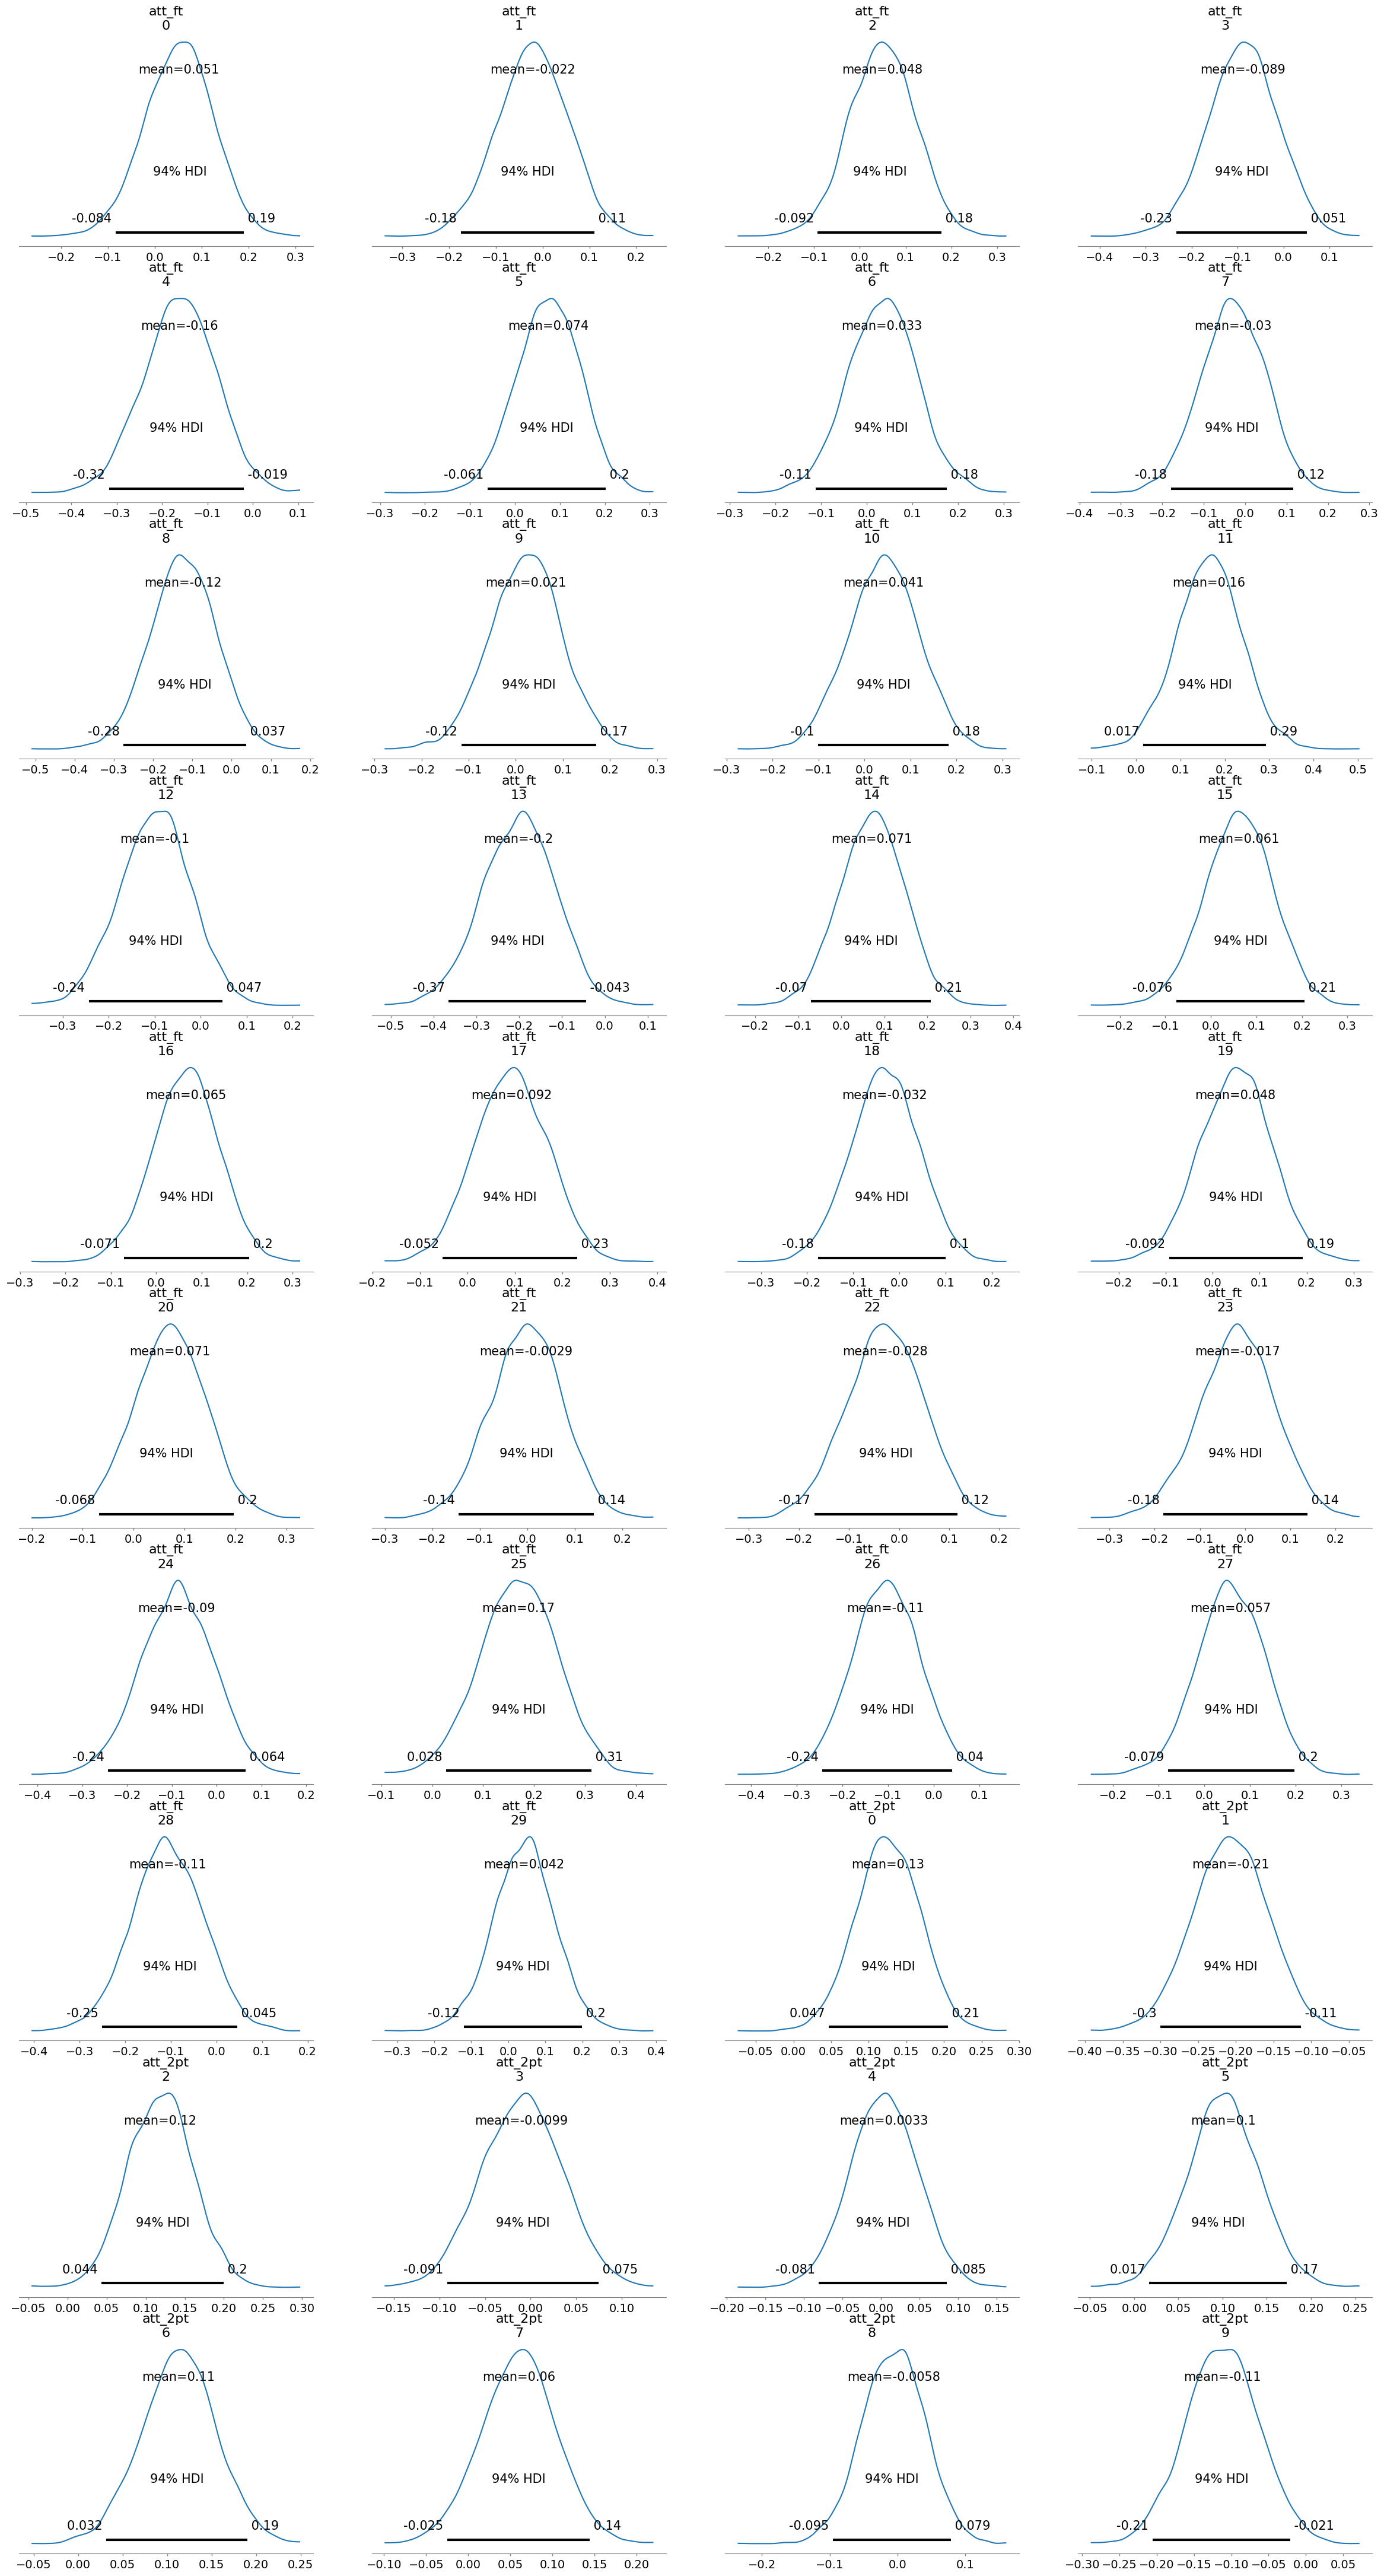

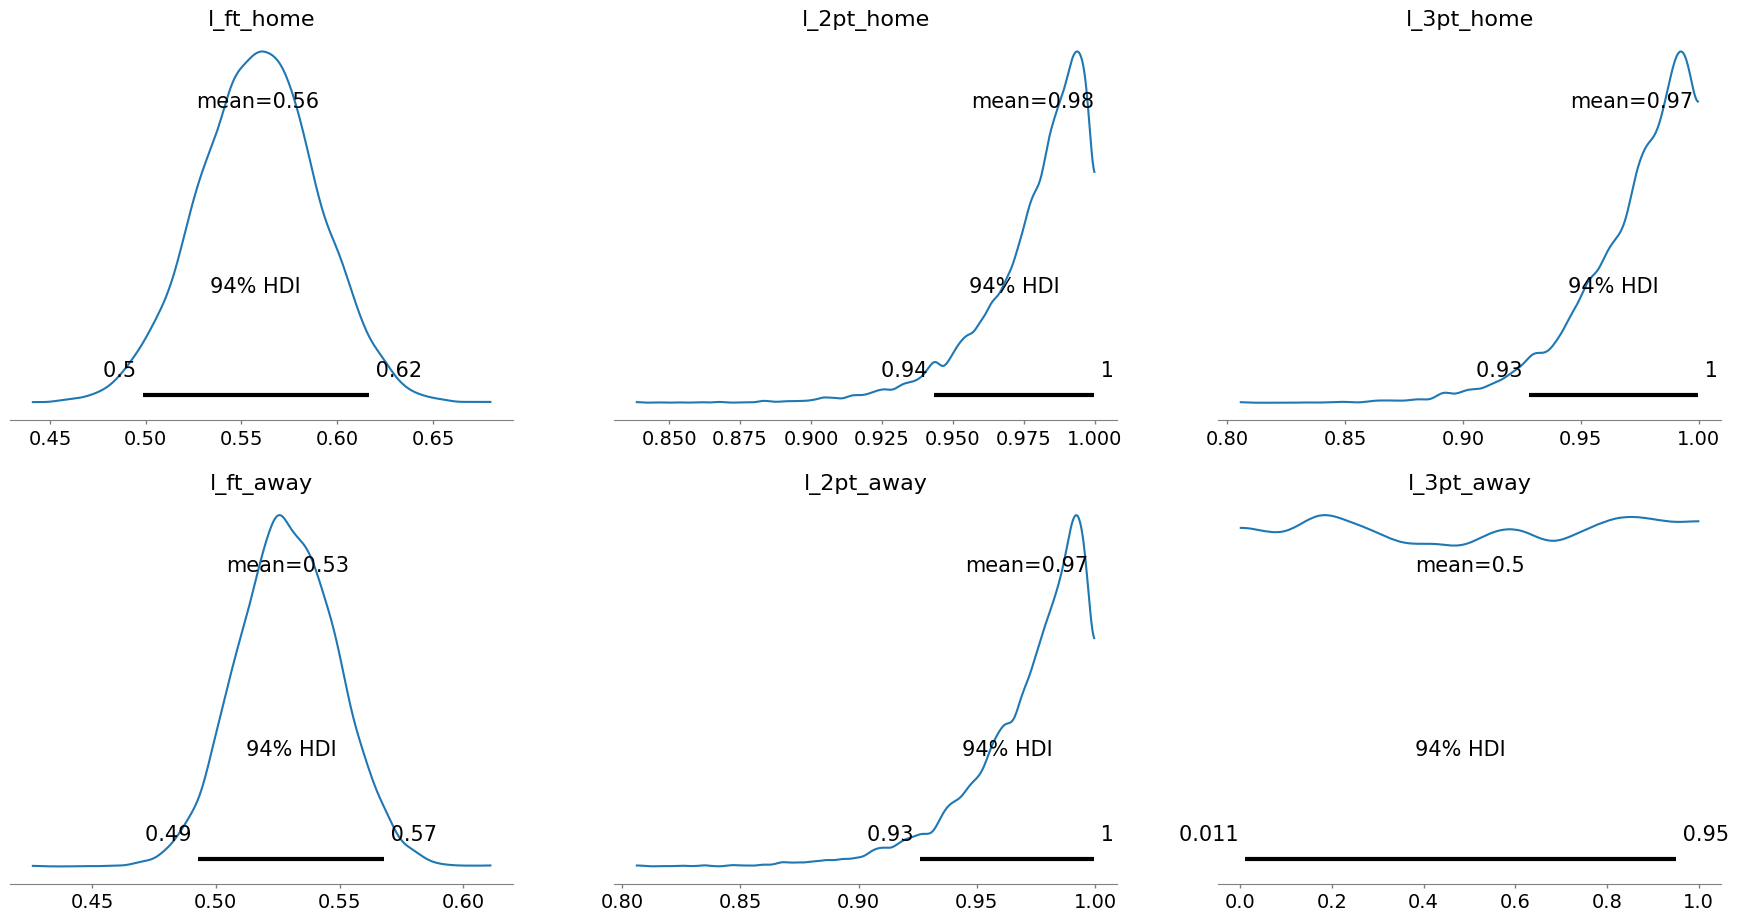

In [15]:
# plots and data
# az.summary(trace_24_25, var_names=['att_ft', 'intercept_ft', 'att_2pt', 'intercept_2pt', 'att_3pt', 'intercept_3pt']).to_csv('24_25_attacking_intensities.csv')
# az.summary(trace_24_25, var_names=['def_ft', 'intercept_ft', 'def_2pt', 'intercept_2pt', 'def_3pt', 'intercept_3pt']).to_csv('24_25_defending_intensities.csv')
# az.summary(trace_24_25, var_names=['l_ft_home', 'l_2pt_home', 'l_3pt_home', 'l_ft_away', 'l_2pt_away', 'l_3pt_away']).to_csv('24_25_scoring_intensities.csv')
az.plot_posterior(trace_24_25, var_names=['att_ft', 'att_2pt', 'att_3pt', 'def_ft', 'def_2pt', 'def_3pt'])
az.plot_posterior(trace_24_25, var_names=['l_ft_home', 'l_2pt_home', 'l_3pt_home', 'l_ft_away', 'l_2pt_away', 'l_3pt_away'])

In [16]:
# Get 2 future games and check 
# Specifically choose matchess with teams without any major roster changes because we didn't model any key/star player effects

# Match 1 Los Angeles Lakers (LAL) vs Oklahhoma City Thunder (OKC)
# LAL +1 strong-ish head coach
# OKC get +1 strong defender 

LAL_idx = team_idx['LAL']
OKC_idx = team_idx['OKC']

LAL_exp_pts = ppc.posterior_predictive['TP_home'][:,:,LAL_idx].mean().values
OKC_exp_pts = ppc.posterior_predictive['TP_away'][:,:,OKC_idx].mean().values

LAL_OKC_spread = LAL_exp_pts - OKC_exp_pts

# Match 2 Miami Heat (MIA) vs Toronto Raptors (TOR)
# MIA +1 good offense
# TOR neutral

MIA_idx = team_idx['MIA']
TOR_idx = team_idx['TOR']

MIA_exp_pts = ppc.posterior_predictive['TP_home'][:,:,MIA_idx].mean().values
TOR_exp_pts = ppc.posterior_predictive['TP_away'][:,:,TOR_idx].mean().values

MIA_TOR_spread = MIA_exp_pts - TOR_exp_pts

# Match 3 Chicago Bulls (CHI) vs Boston Celtics (BOS)

CHI_idx = team_idx['CHI']
BOS_idx = team_idx['BOS']

CHI_exp_pts = ppc.posterior_predictive['TP_home'][:,:,CHI_idx].mean().values
BOS_exp_pts = ppc.posterior_predictive['TP_away'][:,:,BOS_idx].mean().values

CHI_BOS_spread = CHI_exp_pts - BOS_exp_pts

print(f'LAL OKC spread {LAL_OKC_spread}')
print(f'MIA TOR spread {MIA_TOR_spread}')
print(f'CHI BOS spread {CHI_BOS_spread}')


LAL OKC spread 9.28425
MIA TOR spread 14.929874999999996
CHI BOS spread -4.217624999999998


In [41]:
def SpreadPrediction(home_team, away_team):

    home_idx = team_idx[home_team]
    away_idx = team_idx[away_team]

    home_exp_pints = ppc.posterior_predictive['TP_home'][:,:,home_idx].mean().values
    away_exp_pints = ppc.posterior_predictive['TP_away'][:,:,away_idx].mean().values

    final_points = home_exp_pints - away_exp_pints

    if final_points <= 0:
        print(f'{away_team} wins')
    else:
        print(f'{home_team} wins')
    #return home_exp_pints - away_exp_pints



In [42]:
game_1 = SpreadPrediction('CHA', 'NYK')
game_2 = SpreadPrediction('ATL','CLE')
game_3 = SpreadPrediction('MEM', 'NOP')
game_4 = SpreadPrediction('BKN', 'ORL')

# clippers vs min
# pistons vs pacers
# kings vs por
game_5 = SpreadPrediction('MIN', 'LAC')
game_6 = SpreadPrediction('IND', 'DET')
game_7 = SpreadPrediction('POR', 'SAC')






CHA wins
CLE wins
NOP wins
ORL wins
LAC wins
DET wins
SAC wins


In [40]:
game_4

# F, F, F, T, F, T, F

-10.136749999999992

In [ ]:
# 4 T, 6 F